# Quest for lattice symmetries.

In [9]:
""" ----------------------------------------------------------------------------

    lattice_object.py - LR, July 2020

    This defines a class that represents a lattice and allows to perform several
    symmetry operations on it. This is explicitly not for computation, as it is
    a quite inefficient representation. But this can be used to investigate
    the effect of certain operators or rotation and to figure out the symmetries
    of the underlying problem.

    Several old snippets of code have been mashed together to achive this. The
    code could be much cleaner and more structured, however, it should ge the
    stuff done.

---------------------------------------------------------------------------- """
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors

# We need a builder object so that we can perform some operations more easily.
import sys
sys.path.append('../python_gauss_lattice/')
from gauss_lattice import HamiltonianBuilder


class Vertex(object):
    """ Represents a vertex in the grid with all its neighbours (previous and next).
    """
    def __init__(self, links):
        """ Takes in the links in the form [x, -x, y, -y, z, -z] and stores them.
        """
        self.v = np.zeros(shape=(3,3,3), dtype=int)
        self.v[2,1,1] = links[0]
        self.v[0,1,1] = links[1]

        self.v[1,2,1] = links[2]
        self.v[1,0,1] = links[3]

        self.v[1,1,2] = links[4]
        self.v[1,1,0] = links[5]

    def bit_string(self):
        """ Returns the partial bit string, i.e., integer for the vertex.
            Only the "upper" entries are of importance here.
        """
        return self.v[2,1,1] + 2*self.v[1,2,1] + 4*self.v[1,1,2]

    def flip(self):
        self.v[2,1,1] = 1 - self.v[2,1,1]
        self.v[0,1,1] = 1 - self.v[0,1,1]
        self.v[1,2,1] = 1 - self.v[1,2,1]
        self.v[1,0,1] = 1 - self.v[1,0,1]
        self.v[1,1,2] = 1 - self.v[1,1,2]
        self.v[1,1,0] = 1 - self.v[1,1,0]

    def rot90(self, axes):
        self.v = np.rot90(self.v, axes=axes)

    def __repr__(self):
        return "{:03b}".format(self.bit_string())


class LatticeObject(object):
    """ Represents a lattice and lets us perform some operations on it.

        Quite inefficient when thinking of acutal memory consumption, but this is just for
        the purpose of symmetry exploration - way too slow for actual computations.
    """
    def __init__(self, state, L, quiet=False):
        """ Takes an integer as the bit representation for the lattice.
        """
        if not quiet:
            print('Setting up lattice {:d}'.format(state))
        self._update(L)

        self.vertices = np.zeros(shape=L, dtype=Vertex)
        for i in range(self.S[-1]):
            link_indicies = self.get_vertex_links(i)
            links = [(state>>k)&1 for k in link_indicies]
            x, y, z = self.get_3d_indicies(i)
            self.vertices[x,y,z] = Vertex(links)

    def _update(self, L):
        self.L = L
        self.d = len(L)
        self.S = [1]
        for l in L:
            self.S.append(l*self.S[-1])
        self.nb = self.S[-1]*self.d


    def get_3d_indicies(self, i):
        """ Takes in a linear index and maps it to the 3D array.
        """
        return i%self.S[1], i%self.S[2]//self.S[1], i%self.S[3]//self.S[2]

    def get_vertex_links(self, i):
        """ Returns the indices [+x, -x, +y, -y, ...] of the links for the i-th
            vertex *on the full lattice* (not the sublattice) under consideration
            of periodic boundary conditions.

            Note: works only for L^d lattices for now.
        """
        # Shorthand to avoid self all the time.
        L, d, S = self.L, self.d, self.S

        # Index in bit string.
        j = d*i

        # Loop through the dimensions and add the indicies of + and - directions.
        ind = []
        for k in range(1,d+1):
            # Step forward is always 'on site'.
            ind.append(j+k-1)

            # Sep backward in k direction.
            l = j + k -1 - d*S[k-1]
            if i%S[k] < S[k-1]:
                l = l + d*S[k]
            ind.append(l)
        return ind

    def to_int(self):
        """ Get back the integer representation.

            Note: Here it is better to explicitly loop through the indicies to keep
            the correct ordering.
        """
        state = 0
        for i in range(self.S[-1]):
            x, y, z = self.get_3d_indicies(i)
            state += 2**(3*i)*self.vertices[x,y,z].bit_string()
        return int(state)

    def to_bin(self):
        return ('|{:0'+str(self.nb)+'b}> ({:d})').format(self.to_int(), self.to_int())

    # ----
    # Drawing stuff.

    def _get_drawing_links(self, b, a):
        """ Takes coordinates and returns the links to a vertex.
        """
        return [(*b[:k], b[k]+a,*b[k+1:]) for k in range(len(b))]


    def _particle_coordinates(self, link, a=2):
        """ Maps a link to the coordinates on the plot. Returns start and endpoint.
        """
        s = link // len(self.L)
        d = link % len(self.L)

        base = [
            a * (s %self. L[0]),
            a * ((s // self.L[0]) % self.L[1]),
            a * ((s // (self.L[0]*self.L[1])) % self.L[2])
        ]
        l = list(self._get_drawing_links(base, a)[d])
        l[d] -= a/2
        return l


    def _link_coordinates(self, link, a=2):
        """ Maps a link to the coordinates on the plot. Returns start and endpoint.
        """
        s = link // len(self.L)
        d = link % len(self.L)

        base = [
            a * (s % self.L[0]),
            a * ((s // self.L[0]) % self.L[1]),
            a * ((s // (self.L[0]*self.L[1])) % self.L[2])
        ]
        l = self._get_drawing_links(base, a)
        return base, l[d]


    def _draw_3D_lattice(self, a=2.0, pbc=True):
        all_links = []
        for z in range(self.L[2]):
            for y in range(self.L[1]):
                for x in range(self.L[0]):
                    links = self._get_drawing_links([x*a, y*a, z*a], a)
                    for l in links:
                        all_links.append([[x*a, l[0]], [y*a, l[1]], [z*a, l[2]]])
                        if (len(all_links)-1) == 100:
                            self.ax.plot(*all_links[-1], color='red')
                        else:
                            self.ax.plot(*all_links[-1],
                                    color='#838282',
                                    lw=2.5,
                                    zorder=10-a*y
                            )

        return all_links

    def _draw_particle(self, pos, links, a=2.0, colors=['#FCC148', '#F9D792']):
        coord = list(map(lambda x: [x[0]], links[pos]))
        coord[pos%len(links[0])][0] += a/2
        self.ax.plot(xs=coord[0], ys=coord[1], zs=coord[2],
                marker='o',
                markeredgecolor=colors[0],
                markerfacecolor=colors[1],
                markersize=10,
                markeredgewidth=2,
                zorder=10-a*(coord[1][0]//a)+1
        )


    def _draw_state(self, links, colors=['#FCC148', '#F9D792']):
        state = self.to_int()
        for k in range(self.nb):
            if (state>>k)&1:
                self._draw_particle(k, links, colors=colors)

    def _highlight_plaquette(self, p, color='gray', alpha=0.2, a=2):
        lcs = [self._link_coordinates(v) for v in p]

        base = lcs[0][0]
        shift_1 = np.array(lcs[0][1]) - np.array(lcs[0][0])
        shift_2 = np.array(lcs[1][1]) - np.array(lcs[1][0])
        shift_3 = np.array(lcs[2][1]) - np.array(lcs[2][0])
        pts = np.array([
            base,
            base + shift_1,
            base + shift_1 + shift_2,
            base - shift_1 + shift_2 + shift_3
        ])
        tri = a3.art3d.Poly3DCollection([pts], alpha=alpha, color=color)
        self.ax.add_collection3d(tri)

    def _find_flippable_plaquettes(self, builder):
        """ Finds the flippable plaquettes and returns them.
        """
        state = self.to_int()
        pflips = []
        for p in builder.plaquettes:
            if builder.apply_u_dagger(state, p)[0] or builder.apply_u(state, p)[0]:
                pflips.append(p)
        return pflips

    def draw(self, a=2):
        """ 3D plot for the current lattice.
        """
        with plt.style.context('seaborn-notebook'):
            self.fig = plt.figure()
            self.fig.set_size_inches(8,6)
            self.ax = self.fig.add_subplot(111, projection='3d')

            self.ax.view_init(elev=20, azim=-75)
            self.ax.set_axis_off()

            # Draw the actual system.
            links = self._draw_3D_lattice()
            points = self._draw_state(links)

            # Get flippable plaquettes & color them.
            builder = HamiltonianBuilder({'L':self.L}, [], silent=True)
            pflip = self._find_flippable_plaquettes(builder)
            print(f'# of flippable plaquettes: {len(pflip)}')
            for p in builder.plaquettes:
                if p in pflip:
                    pass
#                     self._highlight_plaquette(p[:-1], color='green', alpha=0.1)
                else:
                    pass
                    self._highlight_plaquette(p[:-1], color='red', alpha=0.1)

                    
                    
    # -----
    # Operators.

    def apply_charge_conjugation(self):
        """ Flips all occupancies (spins) on the lattice.
        """
        for f in self.vertices.flat:
            f.flip()

    def apply_parity_flip(self):
        """ Reverses all axes.
        """
        for k in range(self.d):
            self.vertices = np.flip(self.vertices, axis=k)

    def apply_translation(self, axis, extent=1):
        """ Translates steps along a specified axis.
        """
        self.vertices = np.roll(self.vertices, shift=extent, axis=axis)
        
    def apply_rot90(self, axes):
        self.vertices = np.rot90(self.vertices, axes=axes)
        for f in self.vertices.flat:
            f.rot90(axes=axes)

        # Needed for unequal lattices - to get the indicies right.
        self._update(self.vertices.shape)

Setting up lattice 66
|000000000000000001000010> (66)
# of flippable plaquettes: 1
---
|010000001000000000000000> (4227072)
# of flippable plaquettes: 1


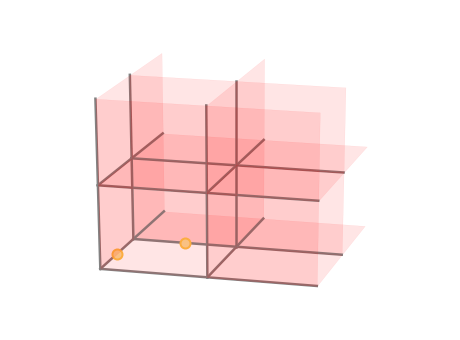

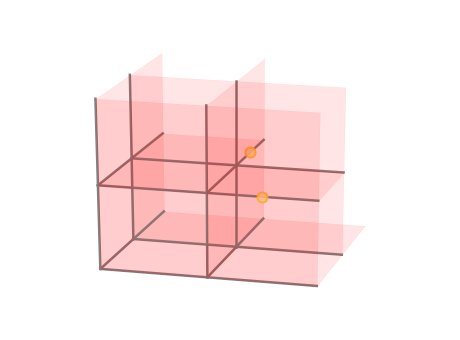

In [17]:
latt = LatticeObject(64+2, [2,2,2])
print(latt.to_bin())
latt.draw()
print('---')

latt.apply_parity_flip()
print(latt.to_bin())
latt.draw()
# # print('---')

In [8]:
lattices = [ 
    3816540,
    3872106,
    5421780,
    5678001,
    7542990,
    7743645,
    9033570,
    9234225,
    11099214,
    11355435,
    12905109,
    12960675
]

Setting up lattice 3816540
|001110100011110001011100> (3816540)
# of flippable plaquettes: 16
---
|100011001110011100110001> (9234225)
# of flippable plaquettes: 16


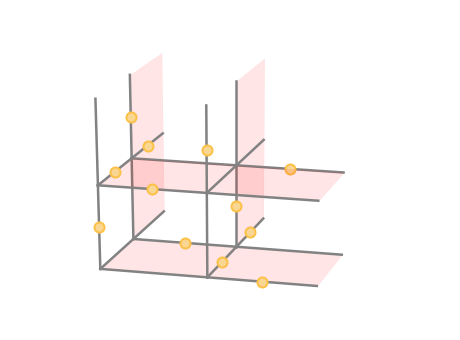

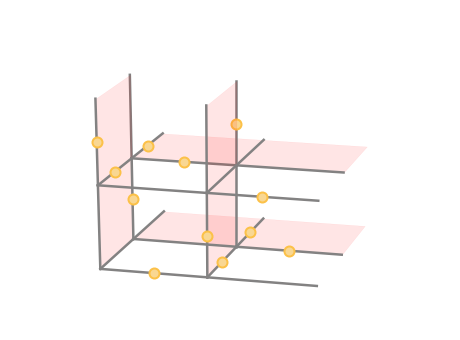

In [33]:
# latt = LatticeObject(80, [4,4,2])
# latt = LatticeObject(3816540, [2,2,2])
latt = LatticeObject(lattices[0], [2,2,2])
print(latt.to_bin())
latt.draw()
print('---')

latt.apply_rot90(axes=(2,0))
latt.apply_rot90(axes=(2,0))
# latt.apply_rot90(axes=(2,0))
print(latt.to_bin())
latt.draw()
# # print('---')

# latt.apply_rot90(axes=(2,1))
# print(latt.to_bin())
# latt.draw()
# print('---')

In [34]:
states = np.array([
    3816540,  
    3872106,  
    5421780,
    5678001,  
    7542990,  
    7743645,  
    9033570,  
    9234225, 
    11099214, 
    11355435, 
    12905109,
    12960675
])
shifts = {
    'x' : [0], 
    'y' : [1], 
    'z' : [2], 
    'xy' : [0,1], 
    'xz' : [0,2], 
    'yz' : [1,2], 
    'xyz' : [0,1,2],
    'parity' : [],
#     'rot180_x' : [1,2],
#     'rot180_y' : [0,2],
#     'rot180_z' : [0,1],
}

maps = {}
for op, shift in shifts.items():
    mlist = np.empty(shape=(len(states)), dtype=int)
    for init, state in enumerate(states):
        latt = LatticeObject(state, [2,2,2], quiet=True)
        if op == 'parity':
            latt.apply_parity_flip()
        elif op.startswith('rot'):
            latt.apply_rot90(axes=shift)
            latt.apply_rot90(axes=shift)
        else:
            for step in shift:
                latt.apply_translation(axis=step, extent=1)
        final = np.where(states == latt.to_int())[0][0]
        mlist[init] = final
        print('{:2s} |{:2d}> = |{:2d}>'.format(op, init+1, final+1))
    maps[op] = mlist
    print('---')

x  | 1> = |12>
x  | 2> = |11>
x  | 3> = | 7>
x  | 4> = | 9>
x  | 5> = | 8>
x  | 6> = |10>
x  | 7> = | 3>
x  | 8> = | 5>
x  | 9> = | 4>
x  |10> = | 6>
x  |11> = | 2>
x  |12> = | 1>
---
y  | 1> = | 8>
y  | 2> = |11>
y  | 3> = |10>
y  | 4> = | 9>
y  | 5> = |12>
y  | 6> = | 7>
y  | 7> = | 6>
y  | 8> = | 1>
y  | 9> = | 4>
y  |10> = | 3>
y  |11> = | 2>
y  |12> = | 5>
---
z  | 1> = |12>
z  | 2> = | 4>
z  | 3> = |10>
z  | 4> = | 2>
z  | 5> = | 8>
z  | 6> = | 7>
z  | 7> = | 6>
z  | 8> = | 5>
z  | 9> = |11>
z  |10> = | 3>
z  |11> = | 9>
z  |12> = | 1>
---
xy | 1> = | 5>
xy | 2> = | 2>
xy | 3> = | 6>
xy | 4> = | 4>
xy | 5> = | 1>
xy | 6> = | 3>
xy | 7> = |10>
xy | 8> = |12>
xy | 9> = | 9>
xy |10> = | 7>
xy |11> = |11>
xy |12> = | 8>
---
xz | 1> = | 1>
xz | 2> = | 9>
xz | 3> = | 6>
xz | 4> = |11>
xz | 5> = | 5>
xz | 6> = | 3>
xz | 7> = |10>
xz | 8> = | 8>
xz | 9> = | 2>
xz |10> = | 7>
xz |11> = | 4>
xz |12> = |12>
---
yz | 1> = | 5>
yz | 2> = | 9>
yz | 3> = | 3>
yz | 4> = |11>
yz | 5> = | 1>
yz | 

In [35]:
es = np.load('eigenstates.npy')

parity_map = np.zeros(shape=(len(shifts),len(es)), dtype=int)
for i, op in enumerate(shifts):
    for j in range(len(es)):
        trans = es[:,j][maps[op]]
        if np.allclose(trans, es[:,j], atol=1e-2):
            parity_map[i,j] = 1
        elif np.allclose(trans, -es[:,j], atol=1e-2):
            parity_map[i,j] = -1
            
parity_map

array([[ 1, -1, -1,  0,  0,  0,  0,  0,  0,  1,  1, -1],
       [ 1, -1, -1,  0,  0,  0,  0,  0,  0,  1,  1, -1],
       [ 1, -1, -1,  0,  0,  0,  0,  0,  0,  1,  1, -1],
       [ 1,  1,  1,  0,  0,  0,  0,  0,  0,  1,  1,  1],
       [ 1,  1,  1,  0,  0,  0,  0,  0,  0,  1,  1,  1],
       [ 1,  1,  1,  0,  0,  0,  0,  0,  0,  1,  1,  1],
       [ 1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1, -1],
       [ 1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1, -1]])

In [84]:
# Define the subspace.
def get_matrix(substates, operator):
    es = np.load('eigenstates.npy')
    subspace = es[:,substates]
    M = np.empty(shape=(len(substates),len(substates)))
    for i in range(len(substates)):
        for j in range(len(substates)):
            final = subspace[:,i][maps[operator]]        
            M[i,j] = np.dot(subspace[:,j], final)
    return M
            
from scipy.linalg import eig

for op in shifts:
    M = get_matrix([6,7,8], op)
#     M = get_matrix([3,4,5], op)
    evals, estates = eig(M)
    print(op, evals)
    print(estates)

x [-0.99992779+0.j  0.99992779+0.j  0.99992779+0.j]
[[-0.43104245 -0.8824179   0.18852445]
 [ 0.90216584 -0.42545735  0.07129458]
 [-0.0172975  -0.20081007 -0.97947722]]
y [-0.99992779+0.j  0.99992779+0.j  0.99992779+0.j]
[[-0.7950066  -0.55267162  0.25004008]
 [-0.38877111  0.14781252 -0.90940084]
 [-0.46564098  0.82018628  0.33237037]]
z [-0.99992779+0.j  0.99992779+0.j  0.99992779+0.j]
[[-0.42681016  0.26142045 -0.86573168]
 [-0.1869594  -0.96213315 -0.19836052]
 [ 0.88480465 -0.0771955  -0.4595234 ]]
xy [ 0.99992779+0.j -0.99992779+0.j -0.99992779+0.j]
[[-0.42681016  0.87584931 -0.22521957]
 [-0.1869594  -0.32911272 -0.92559532]
 [ 0.88480465  0.35294872 -0.30421941]]
xz [ 0.99992779+0.j -0.99992779+0.j -0.99992779+0.j]
[[-0.7950066  -0.47029444 -0.38312738]
 [-0.38877111  0.87985929 -0.27332408]
 [-0.46564098  0.06834302  0.88233064]]
yz [ 0.99992779+0.j -0.99992779+0.j -0.99992779+0.j]
[[-0.43104245  0.80832649  0.40101217]
 [ 0.90216584  0.37754599  0.20870037]
 [-0.0172975  -0.

In [37]:
es[:,[3,4,5]]

array([[-0.36327357,  0.26995404, -0.21245922],
       [ 0.34238708,  0.30974436, -0.19186212],
       [-0.02802897,  0.2848906 ,  0.40991708],
       [ 0.34238777,  0.30974551, -0.19186106],
       [ 0.36327357, -0.26995404,  0.21245922],
       [ 0.02802897, -0.2848906 , -0.40991708],
       [-0.02802972,  0.28489603,  0.4099173 ],
       [-0.3632721 ,  0.2699564 , -0.21245947],
       [-0.34238708, -0.30974436,  0.19186212],
       [ 0.02802972, -0.28489603, -0.4099173 ],
       [-0.34238777, -0.30974551,  0.19186106],
       [ 0.3632721 , -0.2699564 ,  0.21245947]])